In [1]:
import os
import sys
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save = False

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))

In [2]:
from continual_gp.datasets import ToyDataset
from continual_gp.vargp import VARGP
from continual_gp.train_utils import set_seeds

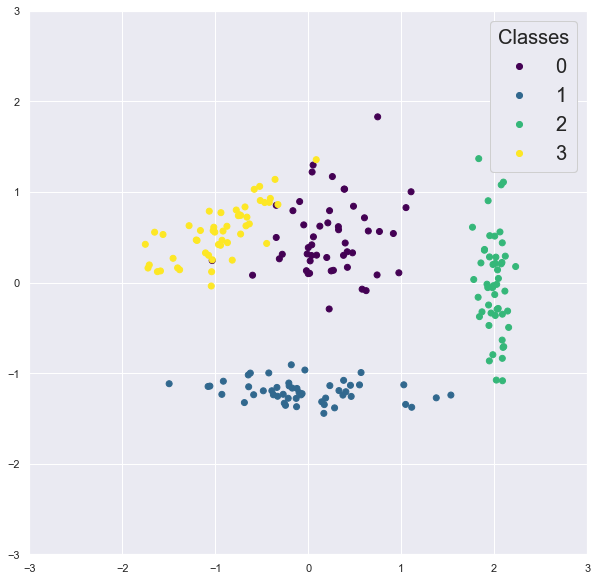

In [3]:
set_seeds(1)

toy_ds = ToyDataset()

fig, ax = plt.subplots(figsize=(10,10))
scatter = ax.scatter(toy_ds.data[:, 0], toy_ds.data[:, 1], c=toy_ds.targets, cmap=plt.get_cmap('viridis'), label=toy_ds.targets)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
legend = ax.legend(*scatter.legend_elements(), title="Classes", title_fontsize=20, fontsize=20)
ax.add_artist(legend)
if save:
    fig.savefig('toy_data.png', bbox_inches='tight', pad_inches=0)

In [4]:
grid_data = torch.cat([v.unsqueeze(-1) for v in torch.meshgrid([torch.arange(-3,3,0.1), torch.arange(-3,3,0.1)])], dim=-1).permute(1, 0, 2)

def plot_task(preds, titles=True, task_id=0):
    out = preds.reshape(*grid_data.shape[:-1], -1)

    fig, axes = plt.subplots(1, 4, sharey=True, sharex=True, figsize=(30, 10))
    fig.subplots_adjust(hspace=0.01, wspace=0.01)

    cim = None
    for i in range(preds.size(-1)):
        toy_ds.filter_by_class([i])

        cim = axes[i].imshow(out[..., i], interpolation='gaussian', cmap='viridis', extent=(-3,3,-3,3), origin='lower')
        # cim = axes[i].scatter(grid_data[..., 0], grid_data[..., 1], c=out[..., i], cmap='viridis')
        axes[i].set(aspect='equal')
        axes[i].set_xlim(-3, 3)
        axes[i].set_ylim(-3, 3)
        axes[i].grid(False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        if titles:
            axes[i].set_title(f'Class {i}', fontsize=50)

        axes[i].scatter(toy_ds.data[toy_ds.task_ids][:, 0], toy_ds.data[toy_ds.task_ids][:, 1], marker='*', facecolor='red', s=200, alpha=0.5)
        # if z is not None:
        #     axes[i].scatter(z[i, ..., 0], z[i, ..., 1], marker='x', facecolor='white', s=100)

    axes[0].set_ylabel(f'After Task {task_id}', fontsize=50)
    
    # fig.colorbar(cim, ax=axes.ravel().tolist(), shrink=0.5)
    toy_ds.filter_by_class()

    return fig, axes

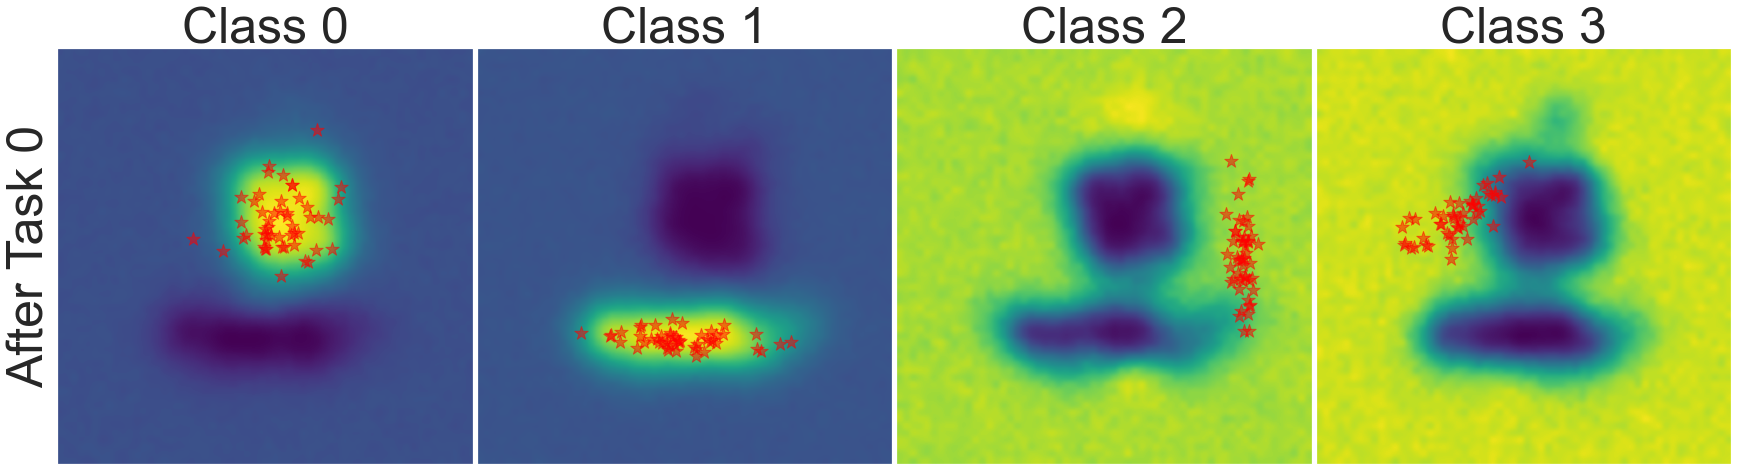

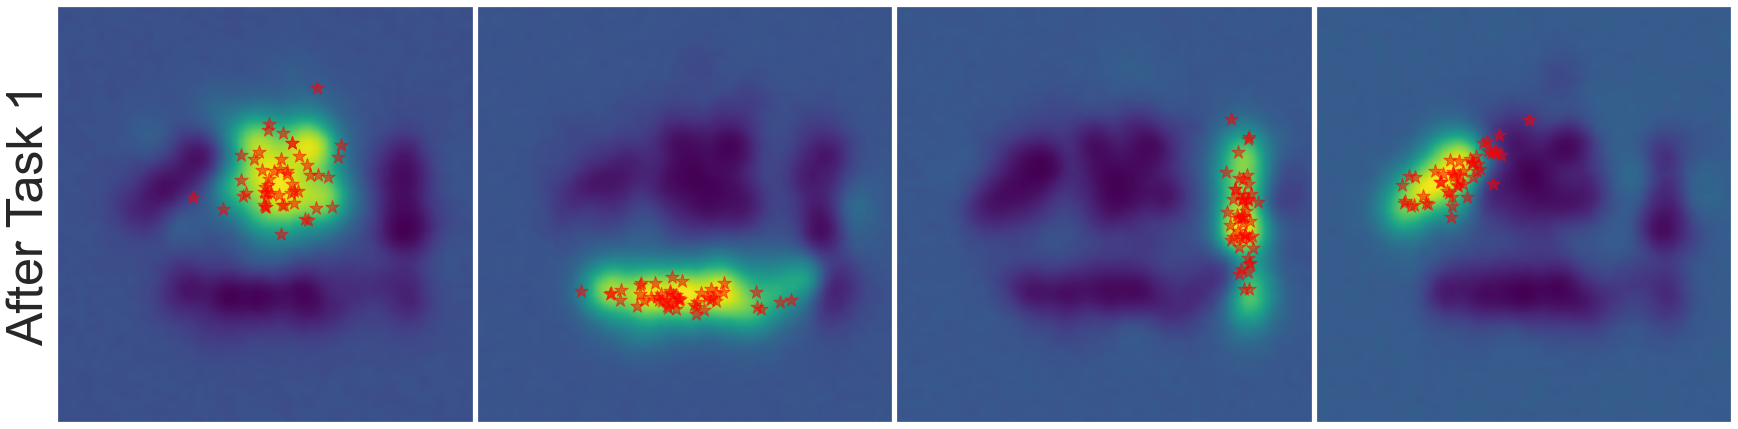

In [6]:
run_dir = 'results/vargp-toy-seed1'

prev_params = []
for t in range(2):
    with torch.no_grad():
        cur_params = torch.load(f'{run_dir}/ckpt{t}.pt')
        gp = VARGP.create_clf(toy_ds, M=20, n_f=100, n_var_samples=20, prev_params=prev_params).to(device)
        gp.load_state_dict(cur_params)

        preds = gp.predict(grid_data.reshape(-1, 2))
        fig, _ = plot_task(preds, titles=(t == 0), task_id=t)
        if save:
            fig.savefig(f'toy_var_gp_{t + 1}.png', bbox_inches='tight', pad_inches=0)

    prev_params.append(cur_params)

In [ ]:
pred_dump = 'results/vcl-toy-seed1'
for t in range(2):
    data = np.load(f'{pred_dump}/grid_pred_probs_{t}.npz')
    preds = torch.from_numpy(np.squeeze(data['probs'], axis=-1).T).float()
    fig, _ = plot_task(preds, titles=(t == 0), task_id=t)
    if save:
        fig.savefig(f'toy_vcl_{t + 1}.png', bbox_inches='tight', pad_inches=0)